In [2]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Preprocessing & Feature Engineering
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Modeling & Evaluation
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score

# Notebook Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')

print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
try:
    train_df_raw = pd.read_csv("train.csv")
    test_df_raw = pd.read_csv("test.csv")
    sample_submission_df = pd.read_csv("sample_submission.csv")
    print("Datasets loaded successfully.")
    print("Training Data Shape:", train_df_raw.shape)
    print("Test Data Shape:", test_df_raw.shape)
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure train.csv, test.csv, and sample_submission.csv are in the same directory.")

Datasets loaded successfully.
Training Data Shape: (18524, 9)
Test Data Shape: (6175, 8)


In [4]:
print("--- Training Data: First 5 Rows ---")
display(train_df_raw.head())

print("\n--- Training Data: Info ---")
train_df_raw.info()

--- Training Data: First 5 Rows ---


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert



--- Training Data: Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


Missing Value Matrix (Train Data)


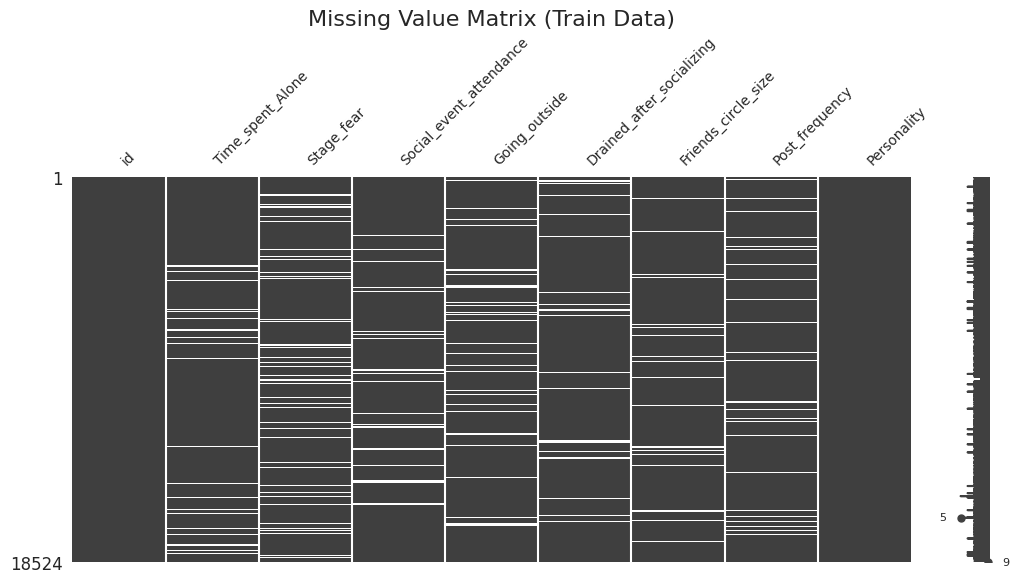


Missing Value Matrix (Test Data)


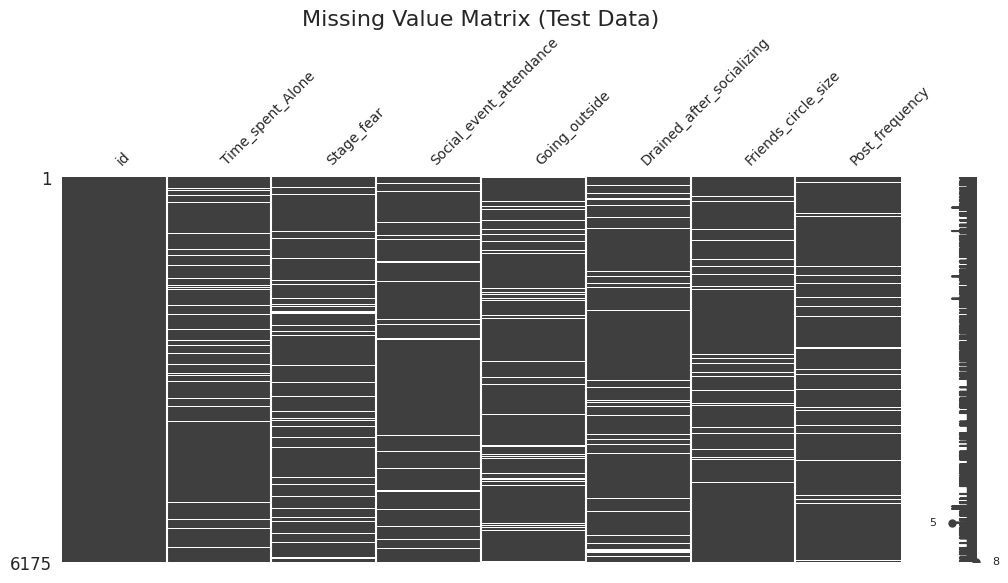

In [5]:
print("Missing Value Matrix (Train Data)")
msno.matrix(train_df_raw, figsize=(12, 5), fontsize=10)
plt.title('Missing Value Matrix (Train Data)', fontsize=16)
plt.show()

print("\nMissing Value Matrix (Test Data)")
msno.matrix(test_df_raw, figsize=(12, 5), fontsize=10)
plt.title('Missing Value Matrix (Test Data)', fontsize=16)
plt.show()

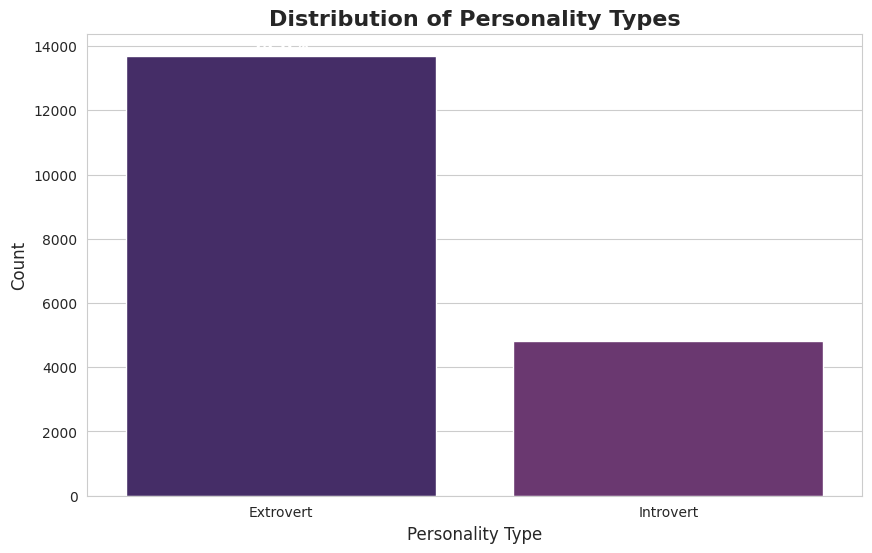

In [6]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Personality', data=train_df_raw, palette=['#432371', '#712F79'])
plt.title('Distribution of Personality Types', fontsize=16, fontweight='bold')
plt.xlabel('Personality Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

total = len(train_df_raw)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')
    
plt.show()

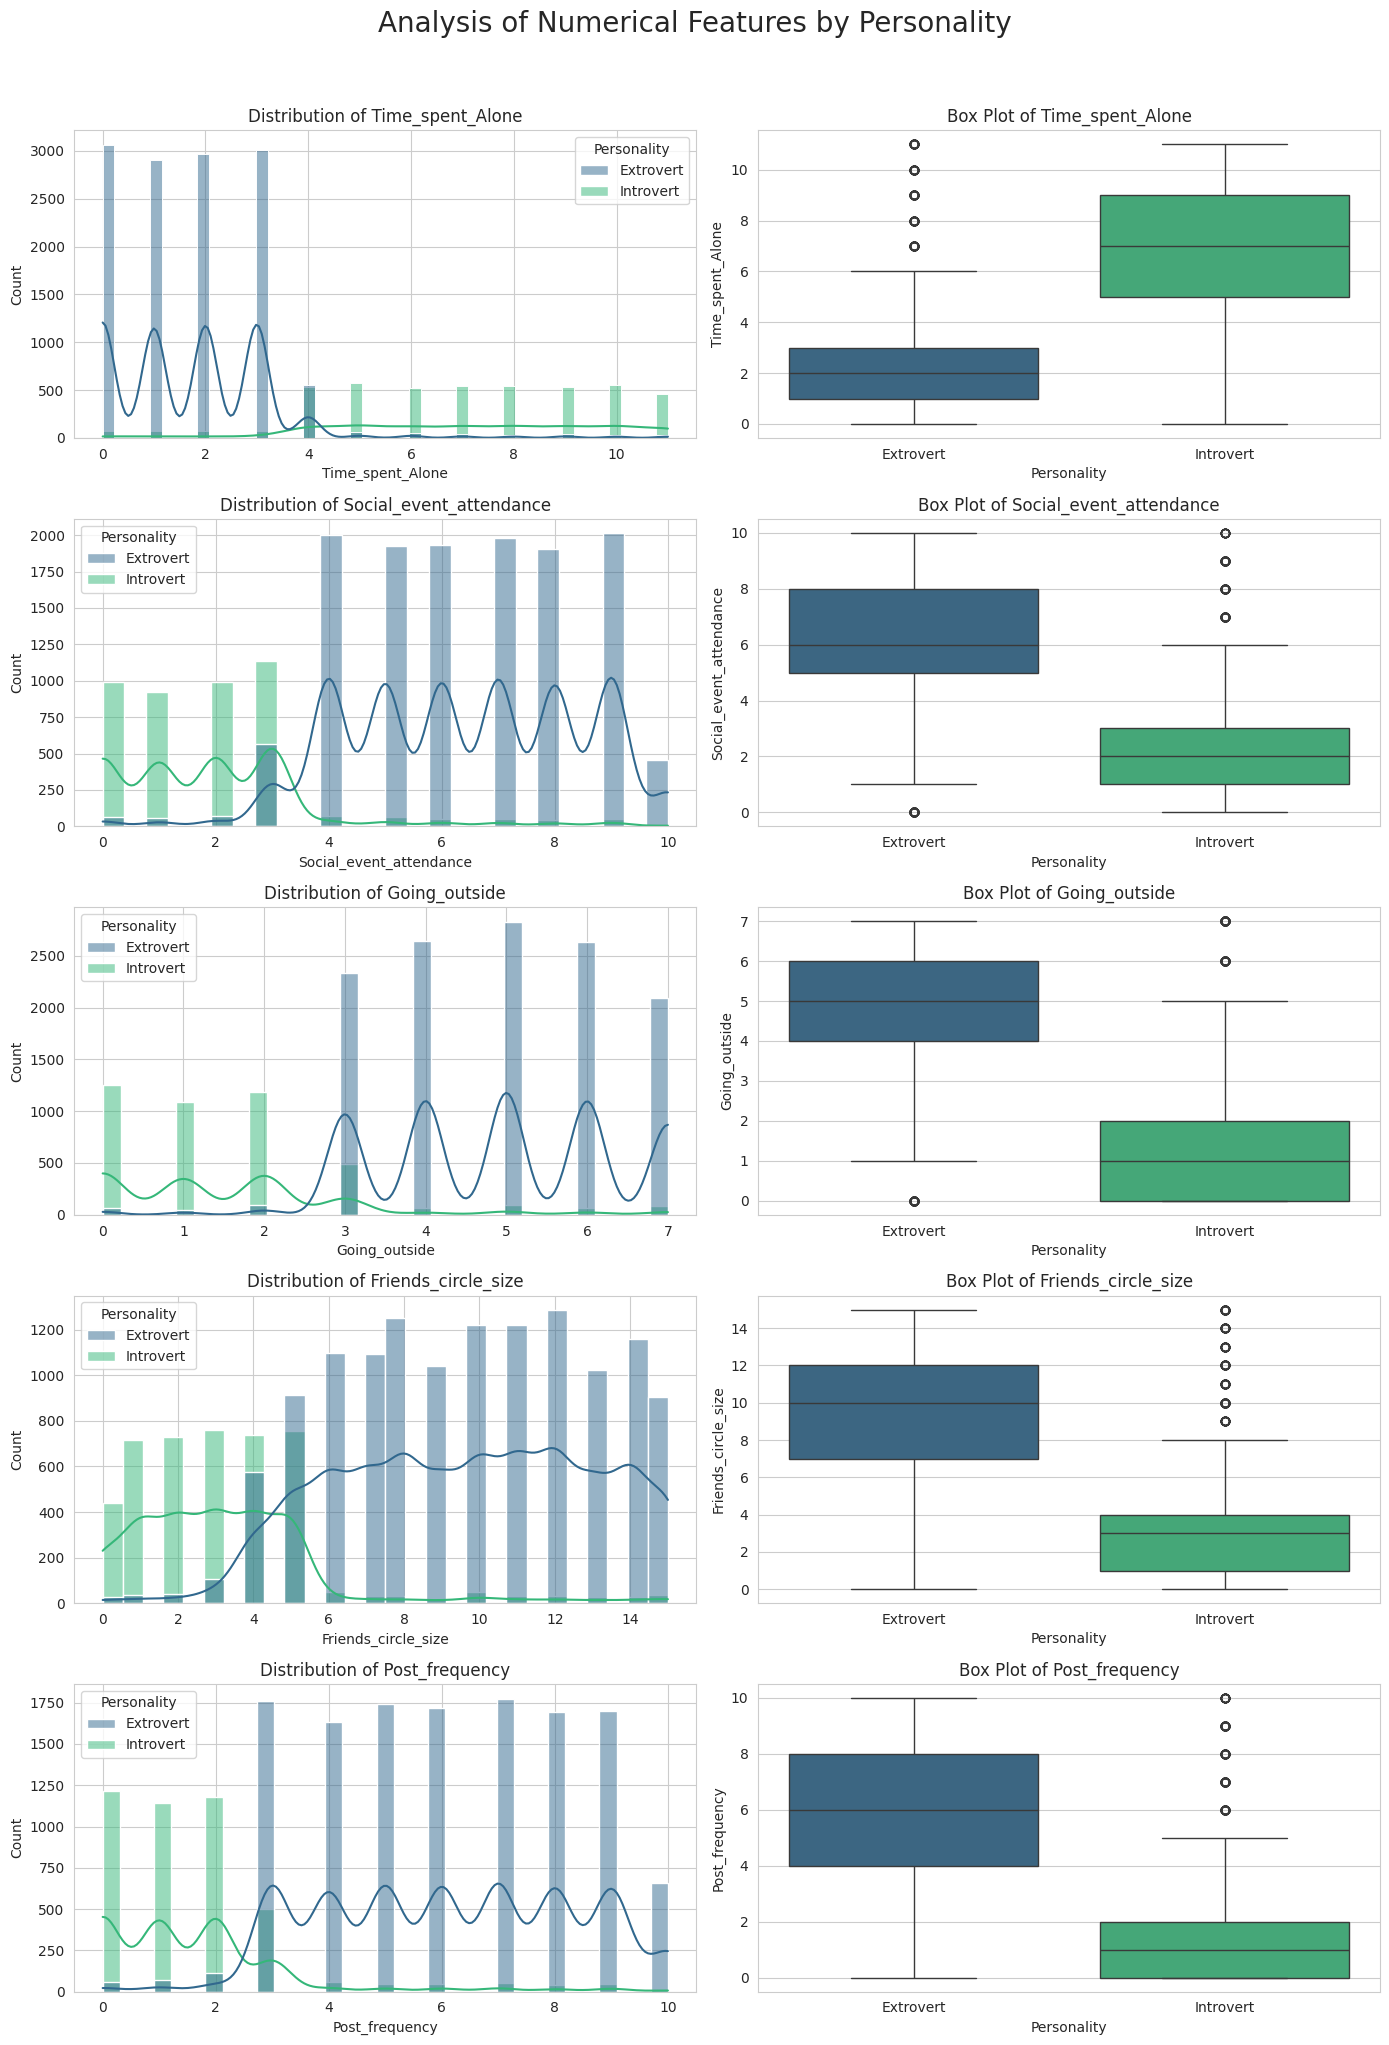

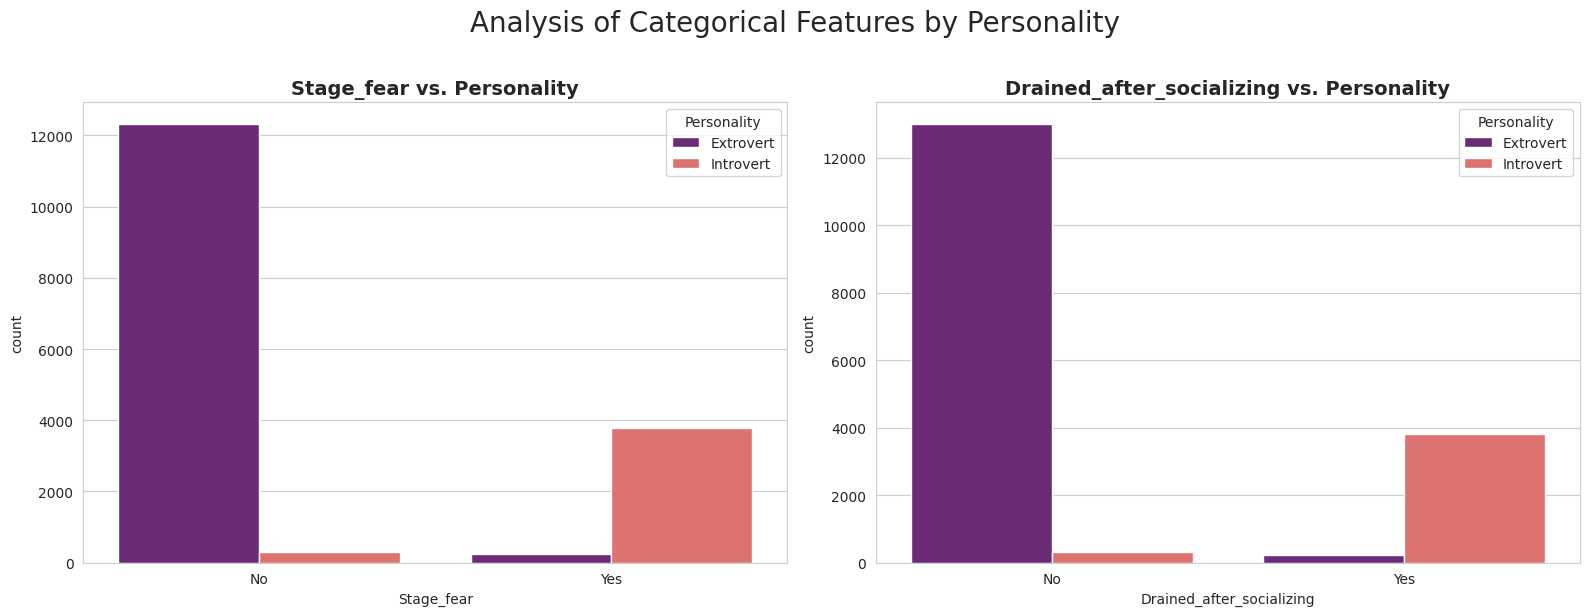

In [7]:
# Numerical features plots
numerical_features = train_df_raw.select_dtypes(include=np.number).columns.drop(['id'])
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(14, 20))
fig.suptitle('Analysis of Numerical Features by Personality', fontsize=20, y=1.02)

for i, col in enumerate(numerical_features):
    sns.histplot(data=train_df_raw, x=col, hue='Personality', kde=True, ax=axes[i, 0], palette='viridis')
    axes[i, 0].set_title(f'Distribution of {col}')
    sns.boxplot(data=train_df_raw, x='Personality', y=col, ax=axes[i, 1], palette='viridis')
    axes[i, 1].set_title(f'Box Plot of {col}')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

# Categorical features plots
categorical_features = ['Stage_fear', 'Drained_after_socializing']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analysis of Categorical Features by Personality', fontsize=20, y=1.02)
for i, col in enumerate(categorical_features):
    sns.countplot(data=train_df_raw, x=col, hue='Personality', ax=axes[i], palette='magma', order=['No', 'Yes'])
    axes[i].set_title(f'{col} vs. Personality', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
# Make copies to avoid modifying the original raw dataframes
train_df = train_df_raw.copy()
test_df = test_df_raw.copy()

# --- FIX: Separate the target variable `y` BEFORE any processing ---
y = train_df['Personality']
train_df = train_df.drop(columns=['Personality'])

# Combine for consistent processing
combined_df = pd.concat([train_df.drop('id', axis=1), test_df.drop('id', axis=1)], ignore_index=True)
print(f"Combined DataFrame shape for processing: {combined_df.shape}")

# --- Feature Engineering ---

# 1. Binary Feature Encoding
binary_cols = ['Stage_fear', 'Drained_after_socializing']
for col in binary_cols:
    combined_df[col] = combined_df[col].map({'Yes': 1, 'No': 0})

# 2. Create flags for missing values before imputation
for col in combined_df.columns:
    if combined_df[col].isnull().any():
        combined_df[f'{col}_missing_flag'] = combined_df[col].isnull().astype(int)

# 3. Interaction and Ratio Features
epsilon = 1e-6
combined_df['Social_Energy_Score'] = (combined_df['Social_event_attendance'] + combined_df['Going_outside']) / (combined_df['Time_spent_Alone'] + epsilon)
combined_df['Online_Offline_Ratio'] = combined_df['Post_frequency'] / (combined_df['Social_event_attendance'] + epsilon)
combined_df['Friends_to_Alone_Ratio'] = combined_df['Friends_circle_size'] / (combined_df['Time_spent_Alone'] + epsilon)

# 4. Polynomial features for strong predictors
for col in ['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']:
    combined_df[f'{col}_sq'] = combined_df[col]**2
    
print("New features created. Shape after feature creation:", combined_df.shape)
print("Engineered features head:")
display(combined_df.head())

Combined DataFrame shape for processing: (24699, 7)
New features created. Shape after feature creation: (24699, 20)
Engineered features head:


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_Alone_missing_flag,Stage_fear_missing_flag,Social_event_attendance_missing_flag,Going_outside_missing_flag,Drained_after_socializing_missing_flag,Friends_circle_size_missing_flag,Post_frequency_missing_flag,Social_Energy_Score,Online_Offline_Ratio,Friends_to_Alone_Ratio,Time_spent_Alone_sq,Social_event_attendance_sq,Friends_circle_size_sq
0,0.0,0.0,6.0,4.0,0.0,15.0,5.0,0,0,0,0,0,0,0,1.000000e+07,0.833333,1.500000e+07,0.0,36.0,225.0
1,1.0,0.0,7.0,3.0,0.0,10.0,8.0,0,0,0,0,0,0,0,9.999990e+00,1.142857,9.999990e+00,1.0,49.0,100.0
2,6.0,1.0,1.0,0.0,NaN,3.0,0.0,0,0,0,0,1,0,0,1.666666e-01,0.000000,4.999999e-01,36.0,1.0,9.0
3,3.0,0.0,7.0,3.0,0.0,11.0,5.0,0,0,0,0,0,0,0,3.333332e+00,0.714286,3.666665e+00,9.0,49.0,121.0
4,1.0,0.0,4.0,4.0,0.0,13.0,NaN,0,0,0,0,0,0,1,7.999992e+00,NaN,1.299999e+01,1.0,16.0,169.0


In [9]:
# 5. KNN Imputation
print("Applying KNN Imputer...")
imputer = KNNImputer(n_neighbors=7)
original_columns = combined_df.columns
imputed_data = imputer.fit_transform(combined_df)
combined_df_imputed = pd.DataFrame(imputed_data, columns=original_columns)

# 6. Scaling
print("Applying MinMaxScaler...")
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df_imputed)
combined_df_processed = pd.DataFrame(scaled_data, columns=combined_df_imputed.columns)

print("Imputation and scaling complete.")
display(combined_df_processed.head())

Applying KNN Imputer...
Applying MinMaxScaler...
Imputation and scaling complete.


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_Alone_missing_flag,Stage_fear_missing_flag,Social_event_attendance_missing_flag,Going_outside_missing_flag,Drained_after_socializing_missing_flag,Friends_circle_size_missing_flag,Post_frequency_missing_flag,Social_Energy_Score,Online_Offline_Ratio,Friends_to_Alone_Ratio,Time_spent_Alone_sq,Social_event_attendance_sq,Friends_circle_size_sq
0,0.000000,0.0,0.6,0.571429,0.0,1.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.882353e-01,9.259258e-08,1.000000e+00,0.000000,0.36,1.000000
1,0.090909,0.0,0.7,0.428571,0.0,0.666667,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.882347e-07,1.269841e-07,6.666660e-07,0.008264,0.49,0.444444
2,0.545455,1.0,0.1,0.000000,1.0,0.200000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.803920e-09,0.000000e+00,3.333333e-08,0.297521,0.01,0.040000
3,0.272727,0.0,0.7,0.428571,0.0,0.733333,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.960784e-07,7.936507e-08,2.444444e-07,0.074380,0.49,0.537778
4,0.090909,0.0,0.4,0.571429,0.0,0.866667,0.642857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.705878e-07,1.785714e-07,8.666658e-07,0.008264,0.16,0.751111


In [10]:
# Label Encode the target variable `y`
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Separate back into training and testing sets
X_processed = combined_df_processed.iloc[:len(train_df)]
X_test_processed = combined_df_processed.iloc[len(train_df):]

print(f"Final Processed Training Data Shape: {X_processed.shape}")
print(f"Final Processed Target Data Shape: {y_encoded.shape}")
print(f"Final Processed Test Data Shape: {X_test_processed.shape}")

Final Processed Training Data Shape: (18524, 20)
Final Processed Target Data Shape: (18524,)
Final Processed Test Data Shape: (6175, 20)


In [11]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_processed, y_encoded):
        X_train, X_val = X_processed.iloc[train_idx], X_processed.iloc[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

        model = lgb.LGBMClassifier(**params)
        
        # Corrected fit method with callbacks
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='accuracy',
                  callbacks=[lgb.early_stopping(100, verbose=False)]) #<-- FIX IS HERE
        
        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))

    return np.mean(scores)

print("--- Starting Hyperparameter Tuning with Optuna ---")
study = optuna.create_study(direction='maximize', study_name='lgbm_personality_tuning')
study.optimize(objective, n_trials=50) # Increase n_trials for a more thorough search

print("\n--- Tuning Complete ---")
print(f"Best trial accuracy: {study.best_value:.4f}")
print("Best hyperparameters found:")
print(study.best_params)

# Store the best parameters in a variable
best_params = study.best_params

[I 2025-07-04 18:07:01,840] A new study created in memory with name: lgbm_personality_tuning


--- Starting Hyperparameter Tuning with Optuna ---


[I 2025-07-04 18:07:04,122] Trial 0 finished with value: 0.9690132999886323 and parameters: {'n_estimators': 619, 'learning_rate': 0.026282214961636914, 'num_leaves': 140, 'max_depth': 14, 'subsample': 0.9209150392307811, 'colsample_bytree': 0.648861737588729, 'reg_alpha': 4.895956237645784e-07, 'reg_lambda': 0.1425755896817873}. Best is trial 0 with value: 0.9690132999886323.
[I 2025-07-04 18:07:05,266] Trial 1 finished with value: 0.9689593334557527 and parameters: {'n_estimators': 1083, 'learning_rate': 0.11737146965051419, 'num_leaves': 180, 'max_depth': 12, 'subsample': 0.6166784359942551, 'colsample_bytree': 0.8476024699659186, 'reg_alpha': 1.1941005597174203e-06, 'reg_lambda': 0.008998304491273465}. Best is trial 0 with value: 0.9690132999886323.
[I 2025-07-04 18:07:05,505] Trial 2 finished with value: 0.9691212476281251 and parameters: {'n_estimators': 414, 'learning_rate': 0.16390463154099894, 'num_leaves': 29, 'max_depth': 7, 'subsample': 0.7800401761061341, 'colsample_bytree


--- Tuning Complete ---
Best trial accuracy: 0.9693
Best hyperparameters found:
{'n_estimators': 1806, 'learning_rate': 0.031054707329214472, 'num_leaves': 46, 'max_depth': 12, 'subsample': 0.7325691691288422, 'colsample_bytree': 0.8382779982531119, 'reg_alpha': 0.6187942785952666, 'reg_lambda': 6.285858445678995e-08}


In [13]:
print("\n--- Training Final Model on Full Data ---")
final_model = lgb.LGBMClassifier(**best_params, objective='binary', random_state=42)
final_model.fit(X_processed, y_encoded)

print("Model training complete. Making predictions on the test set...")
predictions_encoded = final_model.predict(X_test_processed)

# Inverse transform predictions to original labels ('Introvert'/'Extrovert')
predictions = le.inverse_transform(predictions_encoded)

# Create submission file
submission_df = pd.DataFrame({'id': sample_submission_df['id'], 'Personality': predictions})
submission_df.to_csv('submission_v1.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print("--- Submission File Head ---")
display(submission_df.head())


--- Training Final Model on Full Data ---
Model training complete. Making predictions on the test set...

Submission file 'submission.csv' created successfully!
--- Submission File Head ---


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


In [ ]:
print("\n--- Training Final Model on Full Data ---")
final_model = lgb.LGBMClassifier(**best_params, objective='binary', random_state=42)
final_model.fit(X_processed, y_encoded)

print("Model training complete. Making predictions on the test set...")
predictions_encoded = final_model.predict(X_test_processed)

# Inverse transform predictions to original labels ('Introvert'/'Extrovert')
predictions = le.inverse_transform(predictions_encoded)

# Create submission file
submission_df = pd.DataFrame({'id': sample_submission_df['id'], 'Personality': predictions})
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print("--- Submission File Head ---")
display(submission_df.head())